# Ocky_Calibration_Plot

This notebook includes code for the creation of an enzymatic activity plot, Calibration curve, and math associated with the calibration curve.

Mount drive (uses Ben's drive so it may not work for other people. Drive will need to be shared with other users and code paths possibly updated)

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install matplotlib-label-lines

## Calibration Data Dependent

Code within this section is used to generate a calibration curve

### Functions
and dependencies necessary for the enzymatic activity and concentration calibration curves

In [ ]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from labellines import labelLine, labelLines
import numpy as np
#Functions for entire process


#Find files:

def find_files(parent_dir):
  files =[parent_dir+f for f in os.listdir(parent_dir) if os.path.isfile(parent_dir+f)]
  labels = [f[:-4] for f in os.listdir(parent_dir)]
  # print('files in ' + parent_dir +':')
  # for f in labels: print(f)
  return files

#Sort drive files into individual lists
def sort_files(files):
  #Create empty lists
  calibration_files = []

  #Sort inputted files list
  files.sort()

  #Loop through drive list and sort into new lists
  for i, file in enumerate(files):
      calibration_files.append(file)

  print(f'Calibration Files: {calibration_files}')
  return calibration_files

#Check dates of inputted paths. Path is 46 char long, date is 8 char long (54)
def get_date(data):
  date_data = data[46:54]
  print(f'Processing {data[46:]}')
  return date_data


def get_concentration(input_string):
  # Define the regular expression pattern to capture the desired substring
  pattern = re.compile(r'_(\d+)\.csv')

  # Use re.search to find the first match of the pattern in the input_string
  match = re.search(pattern, input_string)

  if match:
    # Extract the captured group (the substring within the parentheses) from the match
    return match.group(1)
  else:
    # Return None if no match is found
    return None

def make_big_df(files):
  #Define headers for all dataframes going forward
  big_df_headers = {'Time': [], 'Chamber':[], 'Intensity': [], 'Concentration':[], 'Date':[], 'File':[], 'i':[]}
  concentrations=[]
  #Create dataframes using headers
  big_df = pd.DataFrame(data=big_df_headers)

  #Use regular expressions to extract chamber number from IntDenCSV
  pattern = r'(\d+)'

  #Loop that creates big_df from files
  for i, file in enumerate(files):
    temp_df = pd.DataFrame(data=big_df_headers)

    date = get_date(file)
    concentration = get_concentration(file)
    concentrations.append(concentration)

    #Convert file to a df
    df = pd.read_csv(file)
    df = df.rename(columns={ df.columns[0]: "Time" })

    #Melt turns IntDenCSV files into nice format
    melt_df = pd.melt(df, id_vars=['Time'], var_name='Chamber', value_name='Intensity')
    melt_df['Chamber'] = melt_df['Chamber'].str.extract(pattern).astype(int)

    #Take good data from melt into correct format
    temp_df.loc[:,'Intensity'] = melt_df.loc[:,'Intensity']
    temp_df['Chamber'] = melt_df['Chamber']
    temp_df['Time'] = melt_df['Time']
    temp_df.loc[:,'Concentration'] = concentration
    temp_df.loc[:,'Date'] = date
    temp_df.loc[:,'File'] = file
    temp_df['i'] = i

    #Put the temp_df into a big_df
    big_df = pd.concat([big_df, temp_df])
    temp_df = temp_df.iloc[0:0] #delete the temp, if not then weird #$@! happens
  big_df.Time = big_df.Time - 1
  print('big_df created!')
  return big_df, concentrations

def calibration_plot(df, concentrations, time_list):
  # Initialize a list to store the results
  results = []
  # Calculate average intensity for each concentration and time point combination
  for concentration in concentrations:
      for target_time in time_list:
          filtered_df = df.loc[(df['Concentration'] == concentration) & (df['Time'] == target_time)]

          # Check if there are any rows in the filtered DataFrame
          if not filtered_df.empty:
              average_intensity = filtered_df['Intensity'].mean()
              standard_deviation = filtered_df['Intensity'].std()

              # Store the result in a dictionary
              result = {
                  'Concentration': concentration,
                  'Time': target_time,
                  'Average Intensity': average_intensity,
                  'Standard Deviation': standard_deviation
              }

              # Append the dictionary to the results list
              results.append(result)

  # Convert the results list of dictionaries to a DataFrame
  calibration_df = pd.DataFrame(results)

  for concentration in concentrations:
      filtered_data = calibration_df[calibration_df['Concentration'] == concentration]
      plt.plot(filtered_data['Time'], filtered_data['Average Intensity'], label='{:,} nM'.format(int(concentration)), linewidth=5)

  return calibration_df

def time_avg_calibration(df, concentrations, target_time):
  # Initialize a list to store the results
  results = []
  # Calculate average intensity for each concentration and time point combination
  time_df = df.loc[(df['Time'] == target_time)]
  for concentration in concentrations:
        filtered_df = time_df.loc[(time_df['Concentration'] == concentration)]

        # Check if there are any rows in the filtered DataFrame
        if not filtered_df.empty:
            average_intensity = filtered_df['Intensity'].mean()
            standard_deviation = filtered_df['Intensity'].std()

            # Store the result in a dictionary
            result = {
                'Concentration': concentration,
                'Average Intensity': average_intensity,
                'Standard Deviation': standard_deviation
            }

            # Append the dictionary to the results list
            results.append(result)

  # Convert the results list of dictionaries to a DataFrame
  result_df = pd.DataFrame(results)

  #Sort the data by concentration
  result_df = result_df.sort_values(by='Concentration')

  return result_df

Locate files from path then create pandas dataframes for the data. Data originates from ImageJ macro output.

In [ ]:
#Old substrate data works at low concentration, does not generate a nice plot.

# old_substrate_files = find_files("/content/drive/My Drive/Rectangle_Calibration/")
# old_substrate_files = sort_files(old_substrate_files)
# old_substrate_df, old_substrate_concentrations = make_big_df(old_substrate_files)

new_substrate_files = find_files("/content/drive/My Drive/New_substrate_files/")
new_substrate_files = sort_files(new_substrate_files)
new_substrate_df, new_substrate_concentrations = make_big_df(new_substrate_files)

Calibration Files: ['/content/drive/My Drive/New_substrate_files/20230911_0.csv', '/content/drive/My Drive/New_substrate_files/20230915_50.csv', '/content/drive/My Drive/New_substrate_files/20230919_30.csv', '/content/drive/My Drive/New_substrate_files/20230919_40.csv', '/content/drive/My Drive/New_substrate_files/20230922_10.csv', '/content/drive/My Drive/New_substrate_files/20230922_20.csv']
Processing 230911_0.csv
Processing 230915_50.csv
Processing 230919_30.csv
Processing 230919_40.csv
Processing 230922_10.csv
Processing 230922_20.csv
big_df created!


Creates enzymatic activity curve for experiments ran using the older substrate solution. Don't run the following code

In [ ]:
# # Old stinky plot dont run this code. uses old substrate data


# # Specify the list of concentrations and time points
# time_points = list(range(1,121))
# # time_points = [0, 15, 30, 45, 60, 75, 90, 105, 120]

# calibration_plot(old_substrate_df, old_substrate_concentrations, time_points)

# title = 'Fluorescence response from varied MMP-9 Concentration'
# xaxis = 'Time (min)'
# yaxis = 'Integrated Intensity'

# #Font
# # font = {'size':20, 'fontweight':'bold'} #BOLD Version
# font = {'size':18}

# #Change title
# plt.title(title, fontdict = font)

# #Change axis labels
# plt.xlabel(xaxis, fontdict = font)
# plt.ylabel(yaxis, fontdict = font)
# # plt.yscale('log')

# labelLines(plt.gca().get_lines(), zorder=2.5, align = False)
# plt.show()

### Enzymatic Assay Activity Plot

This code creates enzymatic activity curve for experiments with new substrate solution. The plot will look nice.

Concentrations are listed in line with the plot using the matplotlib inline library by Corentin Cadiou. Interesting features of this plot include relative position of each concentration and the slope associated with each concentration.

This plot generates the calibration plot data by looking at concentration intensities at a given t. Future code will work with t = 120.

This plot is also used for Michaelis Menten calculations (involving slope)

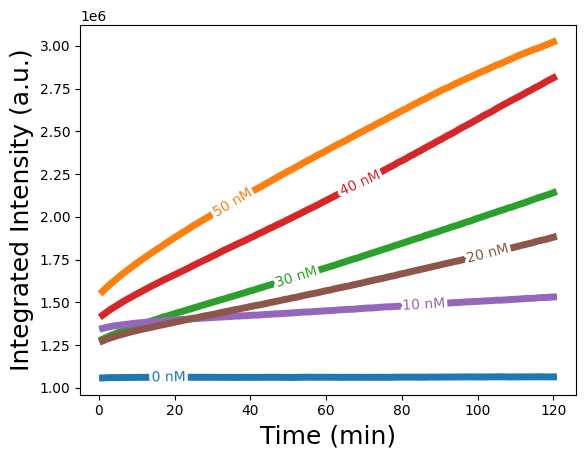

In [ ]:
# Specify the list of concentrations and time points
time_points = list(range(1,121))
# time_points = [0, 15, 30, 45, 60, 75, 90, 105, 120]

calibration_df = calibration_plot(new_substrate_df, new_substrate_concentrations, time_points)

# title = 'Substrate Fluorescence Response\nat Varied MMP-9 Concentrations'
xaxis = 'Time (min)'
yaxis = 'Integrated Intensity (a.u.)'

#Font
# font = {'size':20, 'fontweight':'bold'} #BOLD Version
font = {'size':18}

#Change title
# plt.title(title, fontdict = font)

#Change axis labels
plt.xlabel(xaxis, fontdict = font)
plt.ylabel(yaxis, fontdict = font)
# plt.yscale('log')

labelLines(plt.gca().get_lines(), zorder=2.5, align = True)
plt.show()


### Michaelis Menten

Using the above enzymatic assay activity plot, it should be possible to calculate kcat/km

I think it has something to do with slopes. Strategy will be to calculate the slope for each concentration using numpy line fitting, then plot each slope on the y axis and concentration on x axis

R² value: 0.9738954629818974


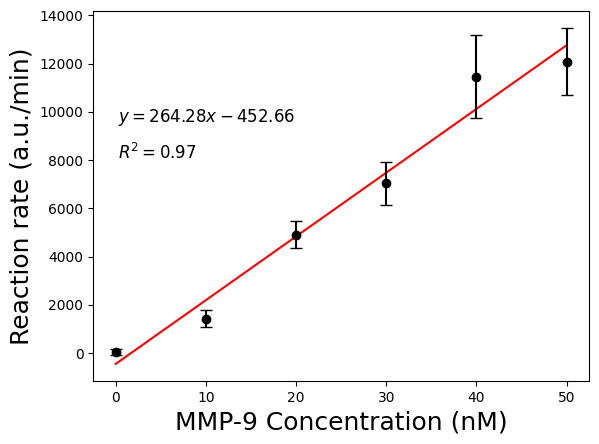

In [ ]:
def michaelis_menten(df, concentrations, chamber_list):
  # Initialize a list to store the results
  results = []
  # Calculate slope for each chamber in each concentration
  for concentration in concentrations:
      for chamber in chamber_list:
          filtered_df = df.loc[(df['Concentration'] == concentration) & (df['Chamber'] == chamber)]

          # Check if there are any rows in the filtered DataFrame
          if not filtered_df.empty:
              coefficients = np.polyfit(filtered_df['Time'], filtered_df['Intensity'], 1)
              # Create the best-fit line equation
              best_fit_line = np.poly1d(coefficients)
              # Store the result in a dictionary
              result = {
                  'Concentration': concentration,
                  'Slope': best_fit_line[1],
                  'Intercept': best_fit_line[0],
                  'Chamber': chamber
              }

              # Append the dictionary to the results list
              results.append(result)

  # Convert the results list of dictionaries to a DataFrame
  calibration_df = pd.DataFrame(results)
  results = []
  # For each concentration, average the slope provided by the chamber, also find std
  for concentration in concentrations:
    filtered_df = calibration_df.loc[(calibration_df['Concentration'] == concentration)]
    # Check if there are any rows in the filtered DataFrame
    if not filtered_df.empty:
        average = filtered_df['Slope'].mean()
        standard_deviation = filtered_df['Slope'].std()
        # Store the result in a dictionary
        result = {
            'Concentration': concentration,
            'Average': average,
            'Standard Deviation': standard_deviation
        }

        # Append the dictionary to the results list
        results.append(result)
        michaelis_df = pd.DataFrame(results)
        michaelis_df = michaelis_df.sort_values(by='Concentration')

  return michaelis_df

# Specify the list of concentrations and time points
chamber_list = list(range(1,161))
michaelis_df = michaelis_menten(new_substrate_df, new_substrate_concentrations, chamber_list)


# michaelis_df = michaelis_menten(calibration_df, new_substrate_concentrations)
michaelis_df['Concentration'] = michaelis_df['Concentration'].astype(float)

coefficients = np.polyfit(michaelis_df['Concentration'], michaelis_df['Average'], 1)

# Create the best-fit line equation
michaelis_line = np.poly1d(coefficients)

# Create a range of x values for the line
x_values = np.linspace(min(michaelis_df['Concentration']), max(michaelis_df['Concentration']), 100)

# Calculate corresponding y values using the best-fit line equation
y_values = michaelis_line(x_values)

# Calculate the predicted y values using the best-fit line equation
predicted_y = michaelis_line(michaelis_df['Concentration'])

# Calculate the total sum of squares (TSS)
mean_y = np.mean(michaelis_df['Average'])
tss = np.sum((michaelis_df['Average'] - mean_y)**2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((michaelis_df['Average'] - predicted_y)**2)

# Calculate R²
r_squared = 1 - (rss / tss)

print(f'R² value: {r_squared}')

# Plot the best-fit line
plt.plot(x_values, y_values, color='r', linestyle='-', label='Best Fit Line', zorder = 0)

# Plot error bars
plt.errorbar(michaelis_df['Concentration'], michaelis_df['Average'], yerr=michaelis_df['Standard Deviation'], color='k', linestyle='None', capsize=4, label='Error Bars')

# Plot the best-fit line
plt.scatter(michaelis_df['Concentration'], michaelis_df['Average'], color ='k', zorder= 1)

# Add R2 annotation to plot
plt.annotate(fr'$y = {michaelis_line[1]:.2f}x  {michaelis_line[0]:.2f}$', xy=(0.05, 0.7), xycoords='axes fraction', fontsize=12)
plt.annotate(fr'$R^2 = {r_squared:.2f}$', xy=(0.05, 0.6), xycoords='axes fraction', fontsize=12)

# Add labels and a title to your plot
xaxis = 'MMP-9 Concentration (nM)'
yaxis = 'Reaction rate (a.u./min)'

font = {'size':18}
plt.xlabel(xaxis, fontdict = font)
plt.ylabel(yaxis, fontdict = font)


#Font
# font = {'size':20, 'fontweight':'bold'} #BOLD Version
font = {'size':18}

#Change axis labels
plt.xlabel(xaxis, fontdict = font)
plt.ylabel(yaxis, fontdict = font)

# Show the plot
plt.show()

In [ ]:
# LOD
michaelis_df
LOD_stdev = 130.690089
LOD = LOD_stdev * 3


m = 264.28
b = 452.66
x = (LOD - b)/m
print(x)
b = 0
x = (LOD - b)/m
print(x)


-0.22926340623581062
1.4835411949447557


### Calibration Curve

A Concentration Calibration Curve can be created after running the previous code. The calibraiton curve is made for time 120.

 
3.971e+04 x + 1.083e+06
R² value: 0.984748469227945


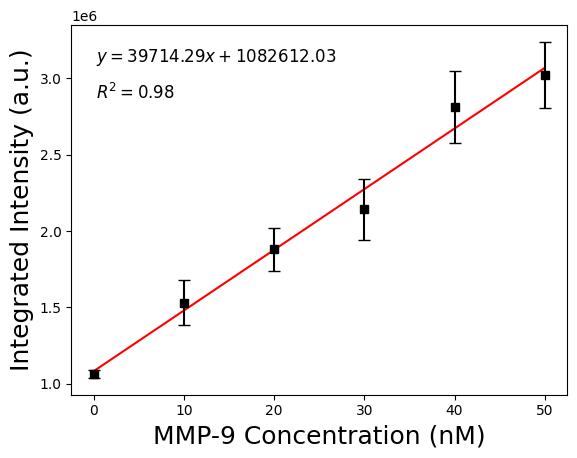

In [ ]:
result_df = time_avg_calibration(new_substrate_df, new_substrate_concentrations, 120)


# Convert 'Concentration' and 'Average Intensity' columns to numeric if they contain strings
result_df['Concentration'] = pd.to_numeric(result_df['Concentration'], errors='coerce')
result_df['Average Intensity'] = pd.to_numeric(result_df['Average Intensity'], errors='coerce')
result_df['Standard Deviation'] = pd.to_numeric(result_df['Standard Deviation'], errors='coerce')

# Calculate the coefficients of the best-fit line (linear regression)
coefficients = np.polyfit(result_df['Concentration'], result_df['Average Intensity'], 1)

# Create the best-fit line equation
best_fit_line = np.poly1d(coefficients)
print(best_fit_line)

# Create a range of x values for the line
x_values = np.linspace(min(result_df['Concentration']), max(result_df['Concentration']), 100)

# Calculate corresponding y values using the best-fit line equation
y_values = best_fit_line(x_values)

# Calculate the predicted y values using the best-fit line equation
predicted_y = best_fit_line(result_df['Concentration'])

# Calculate the total sum of squares (TSS)
mean_y = np.mean(result_df['Average Intensity'])
tss = np.sum((result_df['Average Intensity'] - mean_y)**2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((result_df['Average Intensity'] - predicted_y)**2)

# Calculate R²
r_squared = 1 - (rss / tss)

print(f'R² value: {r_squared}')

# Plot the best-fit line
plt.plot(x_values, y_values, color='r', linestyle='-', label='Best Fit Line')

# Plot error bars
plt.errorbar(result_df['Concentration'], result_df['Average Intensity'], yerr=result_df['Standard Deviation'], color='k', linestyle='None', capsize=4, label='Error Bars')

# Create a scatter plot
plt.plot(result_df['Concentration'], result_df['Average Intensity'], linestyle='None', marker='s', color='k', label='Data')

# Add R2 annotation to plot
plt.annotate(fr'$y = {best_fit_line[1]:.2f}x + {best_fit_line[0]:.2f}$', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)
plt.annotate(fr'$R^2 = {r_squared:.2f}$', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12)

# Add labels and a title to your plot
xaxis = 'MMP-9 Concentration (nM)'
yaxis = 'Integrated Intensity (a.u.)'

font = {'size':18}
plt.xlabel(xaxis, fontdict = font)
plt.ylabel(yaxis, fontdict = font)
# plt.yscale('log')



#Font
# font = {'size':20, 'fontweight':'bold'} #BOLD Version
font = {'size':18}


#Change axis labels
plt.xlabel(xaxis, fontdict = font)
plt.ylabel(yaxis, fontdict = font)

# Show the plot
plt.show()


### Working with calibraiton curve
Finding R-squared values, undestanding numpy line fitting, estimating ROI error

This code calculates the R^2 value for each calibration curve if we had chosen a different t. Values are calculated for every t 1-120.

In [ ]:
#scrath
time_points = list(range(1,121))
results = []

for time in time_points:
  result_df = time_avg_calibration(new_substrate_df, new_substrate_concentrations, time)


  # Convert 'Concentration' and 'Average Intensity' columns to numeric if they contain strings
  result_df['Concentration'] = pd.to_numeric(result_df['Concentration'], errors='coerce')
  result_df['Average Intensity'] = pd.to_numeric(result_df['Average Intensity'], errors='coerce')
  result_df['Standard Deviation'] = pd.to_numeric(result_df['Standard Deviation'], errors='coerce')

  # Calculate the coefficients of the best-fit line (linear regression)
  coefficients = np.polyfit(result_df['Concentration'], result_df['Average Intensity'], 1)

  # Create the best-fit line equation
  best_fit_line = np.poly1d(coefficients)

  # Create a range of x values for the line
  x_values = np.linspace(min(result_df['Concentration']), max(result_df['Concentration']), 100)

  # Calculate corresponding y values using the best-fit line equation
  y_values = best_fit_line(x_values)

  # Calculate the predicted y values using the best-fit line equation
  predicted_y = best_fit_line(result_df['Concentration'])

  # Calculate the total sum of squares (TSS)
  mean_y = np.mean(result_df['Average Intensity'])
  tss = np.sum((result_df['Average Intensity'] - mean_y)**2)

  # Calculate the residual sum of squares (RSS)
  rss = np.sum((result_df['Average Intensity'] - predicted_y)**2)

  # Calculate R²
  r_squared = 1 - (rss / tss)

# Store the result in a dictionary
  result = {
      'R value': r_squared,
      'Time': time,
      'Slope': best_fit_line[1],
      'Intercept': best_fit_line[0]
  }

  # Append the dictionary to the results list
  results.append(result)

  # Convert the results list of dictionaries to a DataFrame
  analysis_df = pd.DataFrame(results)
  print(f'Time: {time} R Square: {r_squared}')

max_r_index = analysis_df['R value'].idxmax()

# Retrieve the row with the maximum 'R value'
row_with_max_r = analysis_df.loc[max_r_index]

print("Row with Highest R value:")
print(row_with_max_r)


Time: 1 R Square: 0.7663600311542855
Time: 2 R Square: 0.7798161457569962
Time: 3 R Square: 0.7932046047446085
Time: 4 R Square: 0.8030849134680687
Time: 5 R Square: 0.8146050910980662
Time: 6 R Square: 0.8248979533086404
Time: 7 R Square: 0.8335236851146652
Time: 8 R Square: 0.8411722769088865
Time: 9 R Square: 0.8477080612310067
Time: 10 R Square: 0.854423596964718
Time: 11 R Square: 0.8614771501480845
Time: 12 R Square: 0.8673024040592555
Time: 13 R Square: 0.8719228866093081
Time: 14 R Square: 0.8779840801679525
Time: 15 R Square: 0.8828284986678
Time: 16 R Square: 0.8873918418797739
Time: 17 R Square: 0.8916855029026346
Time: 18 R Square: 0.8949636770051645
Time: 19 R Square: 0.899264949071199
Time: 20 R Square: 0.9022087372607152
Time: 21 R Square: 0.9060809372913491
Time: 22 R Square: 0.9087213196982725
Time: 23 R Square: 0.9122013845291037
Time: 24 R Square: 0.9151385392936126
Time: 25 R Square: 0.9179057367149297
Time: 26 R Square: 0.9206464368718622
Time: 27 R Square: 0.92316

In [ ]:
print(michaelis_line)
print(michaelis_line[0])
print(michaelis_line[1])

def conc_eq(intensity, best_fit_line):
  x = (intensity - best_fit_line[0])/best_fit_line[1]
  return x

x = conc_eq(100, michaelis_line)
print(x)

 
264.3 x - 452.7
-452.6556436994744
264.2785310357674
2.091186300807303


## Cell data dependent

### Functions
The previous code sections must be ran to generate the calibration curve and equation. The following code will use that equation to translate cell intensities into cell mmp9 concentrations. Below are the functions for this translation.

In [ ]:
import re
import os
import pandas as pd
#Functions for entire process


#Find files:

def find_files(parent_dir):
  # parent_dir = "/content/drive/My Drive/MMP9 Before Petdet/"
  files =[parent_dir+f for f in os.listdir(parent_dir) if os.path.isfile(parent_dir+f)]
  labels = [f[:-4] for f in os.listdir(parent_dir)]
  # print('files in ' + parent_dir +':')
  # for f in labels: print(f)
  return files

#Sort drive files into individual lists
def sort_drive(files):
  #Create empty lists
  intden_files = []
  petdet_files = []

  #Sort inputted files list
  files.sort()

  #Loop through drive list and sort into new lists
  for i, file in enumerate(files):
    if i % 2 == 0:
      intden_files.append(file)
    else:
      petdet_files.append(file)

  print(f'Inteden_files: {intden_files}')
  print(f'petdet_files: {petdet_files}')
  return intden_files, petdet_files



#Check dates of inputted paths. Path is 43 char long, date is 8 char long (51)
def get_date_with_pet(data, pet):
  date_data = data[43:51]
  date_pet = pet[43:51]
  print(date_data)
  print(date_pet)
  if date_data != date_pet:
    print(f'Error: mismatch between {data[43:]} and {pet[43:]}')
  else:
    print(f'Processing {data[43:]} + {pet[43:]}')
  return date_data, date_pet

def extract_sample_name_pet(input_string):
    # Define the regular expression pattern to capture the desired substring
    pattern = r'\/\d{8}_(\w+)_(?:IntDen|petdet)\.csv$'

    # Use re.search to find the first match of the pattern in the input_string
    match = re.search(pattern, input_string)

    if match:
        # Extract the captured group (the substring within the parentheses) from the match
        return match.group(1)
    else:
        # Return None if no match is found
        return None


def extract_sample_name(input_string):
    # Define the regular expression pattern to capture the desired substring
    pattern = r'/\d+_(.*?)_raw_cells_only\.csv'


    # Use re.search to find the first match of the pattern in the input_string
    match = re.search(pattern, input_string)

    if match:
        # Extract the captured group (the substring within the parentheses) from the match
        return match.group(1)
    else:
        # Return None if no match is found
        return None

def create_cells_df_and_background_df(data, pet):
  #Remove first column of data
  cells_df = pd.read_csv(data)
  cells_df = cells_df.iloc[:,1:] #remove index column

  #Make copy of cells_df and rename to background
  background_df = cells_df.copy()

  #Convert petdet csv into df
  pet_df = pd.read_csv(pet)

  #Count number of cells
  cells = pet_df['Cell'].sum()
  print(f'{pet[43:]} contains {cells} cells')

  #Loop through pet_df cell column and separate data into two dfs
  for i in range(len(pet_df.index)):

    #Accessing correct columns
    name = 'Chamber '+ str(i+1) + ' RawIntDen'

    #If there is a cell, remove that data from the background list
    if pet_df.loc[i]['Cell'] == 1:
      background_df = background_df.drop([name],  axis=1)

    #If there isn't a cell, remove that data from the cell list
    else:
      cells_df = cells_df.drop([name],  axis=1)

  return cells_df, background_df

#Functions for the purpose of calculating concentrations.

def get_date(data):
  date_data = data[50:58]
  # date_pet = pet[43:51]
  # print(date_data)
  # print(date_pet)
  # if date_data != date_pet:
  #   print(f'Error: mismatch between {data[43:]} and {pet[43:]}')
  # else:
  #   print(f'Processing {data[43:]} + {pet[43:]}')
  return date_data


def make_big_cells_df(files):
  #Define headers for all dataframes going forward
  big_df_headers = {'Time': [], 'Chamber':[], 'Intensity': [], 'Calculated_Concentration':[], 'Cell Type':[], 'Date':[], 'File':[], 'i':[]}

  #Create dataframes using headers
  big_df = pd.DataFrame(data=big_df_headers)

  #Use regular expressions to extract chamber number from IntDenCSV
  pattern = r'(\d+)'

  #Loop that creates big_df from files
  for i, file in enumerate(files):
    print(file)
    temp_df = pd.DataFrame(data=big_df_headers)

    date = get_date(file)
    cell_type = extract_sample_name(file)

    #Convert file to a df
    df = pd.read_csv(file)
    df = df.rename(columns={ df.columns[0]: "Time" })

    #Melt turns IntDenCSV files into nice format
    melt_df = pd.melt(df, id_vars=['Time'], var_name='Chamber', value_name='Intensity')
    melt_df['Chamber'] = melt_df['Chamber'].str.extract(pattern).astype(int)

    #Take good data from melt into correct format
    temp_df.loc[:,'Intensity'] = melt_df.loc[:,'Intensity']
    temp_df['Chamber'] = melt_df['Chamber']
    temp_df['Time'] = melt_df['Time']
    temp_df.loc[:,'Cell Type'] = cell_type
    temp_df.loc[:,'Date'] = date
    temp_df.loc[:,'File'] = file
    temp_df['i'] = i

    #Put the temp_df into a big_df
    big_df = pd.concat([big_df, temp_df])
    temp_df = temp_df.iloc[0:0] #delete the temp, if not then weird #$@! happens
  # big_df.Time = big_df.Time - 1 #not sure why this is here
  print('big_df created!')
  return big_df

def get_intensity_at_time(dataframe, target_time):
  time_selected_df = dataframe[dataframe['Time']== target_time]
  return time_selected_df

def calculate_concentration(dataframe, best_fit_line):
  result_dataframe = dataframe.copy()
  y = result_dataframe['Intensity']
  b = best_fit_line[0]
  m = best_fit_line[1]
  # y = mx + b rearranges to x = (y - b) / m
  result_dataframe['Calculated_Concentration'] = (y - b) / m
  return result_dataframe

def calculate_concentration_by_rate(cell_intensity_df, cell_intensity_files, michaelis_line, time_delta):
  result_dataframe = cell_intensity_df.copy()
  results = []
  time_list = list(range(10,121,time_delta))
  for file in cell_intensity_files:
    chamber_list = []
    individual_file_df = result_dataframe.loc[result_dataframe['File'] == file]
    chamber_list = list(set(individual_file_df['Chamber'].tolist()))

    for chamber in chamber_list:
      individual_chamber_df = individual_file_df.loc[individual_file_df['Chamber'] == chamber]
      cell_type = individual_chamber_df['Cell Type'].iloc[0]

      for interval in time_list:

        individual_time_df = individual_chamber_df.loc[individual_chamber_df['Time'] <= interval]

        coefficients = np.polyfit(individual_time_df['Time'], individual_time_df['Intensity'], 1)
        chamber_best_fit_line = np.poly1d(coefficients)
        y = chamber_best_fit_line[1]
        b = michaelis_line[0]
        m = michaelis_line[1]
        # y = mx + b rearranges to x = (y - b) / m
        calculated_concentration = (y - b) / m

        # Store the result in a dictionary
        result = {
        'Cell Type': cell_type,
        'Chamber Reaction Rate': chamber_best_fit_line[1],
        'Intercept': chamber_best_fit_line[0],
        'Chamber': chamber,
        'Path': file,
        'Time Interval': interval,
        'Calculated Concentration': calculated_concentration
        }
        # Append the dictionary to the results list
        results.append(result)
  # Convert the results list of dictionaries to a DataFrame
  rates_df = pd.DataFrame(results)
  return rates_df

In [ ]:
time_list = list(range(10,121,1))
for interval in time_list:
  print(interval)

del interval

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


### File conversion
The following code was used to convert ImageJ csv files into friendlier to work with files, saved in google drive. The code doesn't need to be ran again because the files are saved in drive and can be referenced in later code.

Files that were collected with 2x2 binning are:
> 20221116_MDA MB 231_raw_cells_only.csv

> 20221102_MDA +PMA_raw_cells_only.csv

> 20221012_MDA +PMA_raw_cells_only.csv

> 20220706_MDA MB 231_raw_cells_only.csv

In [ ]:
#Create csv files of raw cell intensities only. This code does not need to be ran again.
files = find_files(parent_dir = "/content/drive/My Drive/MMP9 Before Petdet/")
save_cells_path = '/content/drive/My Drive/Calculated_Concentrations/'

#Sort the google drive and separate files
intden_files, petdet_files = sort_drive(files)

#Loop through each file within the lists, zip allows iteration of two lists in parallel
for intden_file, petdet_file in zip(intden_files, petdet_files):

  #Get the dates of each file, make sure they match
  date_data, date_pet = get_date_with_pet(intden_file, petdet_file)
  if date_data == date_pet:
    #Get cell type from file name
    cell_type = extract_sample_name_pet(intden_file)

    #Rename Cells if necessary
    if cell_type == 'MDA': cell_type = 'MDA MB 231'
    if cell_type == 'PMA': cell_type = 'MDA + PMA'

    #Create dataframes
    cells_df, _ = create_cells_df_and_background_df(intden_file, petdet_file)

    #Declare paths for processed files
    cells_formatted_name = f"{save_cells_path}{date_data}_{cell_type}_raw_cells_only.csv"

    #Save processed files
    cells_df.to_csv(cells_formatted_name)


    print(f"{cells_formatted_name} saved")



  #Stop loop if the dates of files do not match
  else:
    break

print('we done')

Inteden_files: ['/content/drive/My Drive/MMP9 Before Petdet/20220527_A375_IntDen.csv', '/content/drive/My Drive/MMP9 Before Petdet/20220607_A375_IntDen.csv', '/content/drive/My Drive/MMP9 Before Petdet/20220706_MDA_IntDen.csv', '/content/drive/My Drive/MMP9 Before Petdet/20220803_A375_IntDen.csv', '/content/drive/My Drive/MMP9 Before Petdet/20221012_PMA_IntDen.csv', '/content/drive/My Drive/MMP9 Before Petdet/20221102_PMA_IntDen.csv', '/content/drive/My Drive/MMP9 Before Petdet/20221109_PMA_IntDen.csv', '/content/drive/My Drive/MMP9 Before Petdet/20221116_MDA_IntDen.csv', '/content/drive/My Drive/MMP9 Before Petdet/20221121_MDA_IntDen.csv']
petdet_files: ['/content/drive/My Drive/MMP9 Before Petdet/20220527_A375_petdet.csv', '/content/drive/My Drive/MMP9 Before Petdet/20220607_A375_petdet.csv', '/content/drive/My Drive/MMP9 Before Petdet/20220706_MDA_petdet.csv', '/content/drive/My Drive/MMP9 Before Petdet/20220803_A375_petdet.csv', '/content/drive/My Drive/MMP9 Before Petdet/20221012_

### Calculate concentrations

Import the csv files of cell intensities from google drive, then convert the files into a dataframe. From this dataframe, choose cells form a selected_time and calculate the concentration of the cells from the cell intensity. Return the reults into a new dataframe called results_df.

### Calculate concentrations through rate (CH Chen)

Double capture is causing some chambers to have very high concentration values. Only interested in single cell capture, so I need to go back into the data and find instances of double capture that were missed initially and remove them. This is the list of chambers containing double capture which were removed.

20221121_MDA MB 231_raw_cells_only.csv Chambers: 10, 15, 37, 11, 118, 119


In [ ]:
#Calculate the concentrations of MMP9 in cell cexperiments from raw intensitesi

cell_intensity_files = find_files("/content/drive/My Drive/Calculated_Concentrations/")
cell_intensity_files = sort_files(cell_intensity_files)
cell_intensity_df = make_big_cells_df(cell_intensity_files)

selected_time = 120

# time_selected_intensity_df = get_intensity_at_time(cell_intensity_df, selected_time)
# results_df = calculate_concentration(time_selected_intensity_df, best_fit_line)

rates_df = calculate_concentration_by_rate(cell_intensity_df, cell_intensity_files, michaelis_line, 10)
rates_df

Calibration Files: ['/content/drive/My Drive/Calculated_Concentrations/20220527_A375_raw_cells_only.csv', '/content/drive/My Drive/Calculated_Concentrations/20220607_A375_raw_cells_only.csv', '/content/drive/My Drive/Calculated_Concentrations/20220706_MDA MB 231_raw_cells_only.csv', '/content/drive/My Drive/Calculated_Concentrations/20220803_A375_raw_cells_only.csv', '/content/drive/My Drive/Calculated_Concentrations/20221012_MDA + PMA_raw_cells_only.csv', '/content/drive/My Drive/Calculated_Concentrations/20221102_MDA + PMA_raw_cells_only.csv', '/content/drive/My Drive/Calculated_Concentrations/20221109_MDA + PMA_raw_cells_only.csv', '/content/drive/My Drive/Calculated_Concentrations/20221116_MDA MB 231_raw_cells_only.csv', '/content/drive/My Drive/Calculated_Concentrations/20221121_MDA MB 231_raw_cells_only.csv']
/content/drive/My Drive/Calculated_Concentrations/20220527_A375_raw_cells_only.csv
/content/drive/My Drive/Calculated_Concentrations/20220607_A375_raw_cells_only.csv
/conten

,Cell Type,Chamber Reaction Rate,Intercept,Chamber,Path,Time Interval,Calculated Concentration
0,A375,1572.227273,1.164440e+06,128.0,/content/drive/My Drive/Calculated_Concentrati...,10,7.661927
1,A375,4213.802597,1.147393e+06,128.0,/content/drive/My Drive/Calculated_Concentrati...,20,17.657349
2,A375,17511.006855,1.039685e+06,128.0,/content/drive/My Drive/Calculated_Concentrati...,30,67.972462
3,A375,25989.732404,9.434468e+05,128.0,/content/drive/My Drive/Calculated_Concentrati...,40,100.054999
4,A375,30835.537195,8.722927e+05,128.0,/content/drive/My Drive/Calculated_Concentrati...,50,118.390975
...,...,...,...,...,...,...,...
5899,MDA MB 231,1076.393406,1.024229e+06,120.0,/content/drive/My Drive/Calculated_Concentrati...,80,5.785748
5900,MDA MB 231,967.682306,1.027276e+06,120.0,/content/drive/My Drive/Calculated_Concentrati...,90,5.374398
5901,MDA MB 231,1001.492801,1.026138e+06,120.0,/content/drive/My Drive/Calculated_Concentrati...,100,5.502333
5902,MDA MB 231,1330.717024,1.014596e+06,120.0,/content/drive/My Drive/Calculated_Concentrati...,110,6.748080


## Enough is enough
Having a joker moment and calculating instantaneous slopes

In [ ]:
def rate_deriver(cell_intensity_df, cell_intensity_files, michaelis_line, time_delta):
  result_dataframe = cell_intensity_df.copy()
  results = []
  time_list = list(range(10,121,time_delta))
  for file in cell_intensity_files:
    chamber_list = []
    individual_file_df = result_dataframe.loc[result_dataframe['File'] == file]
    chamber_list = list(set(individual_file_df['Chamber'].tolist()))

    for chamber in chamber_list:
      individual_chamber_df = individual_file_df.loc[individual_file_df['Chamber'] == chamber]
      cell_type = individual_chamber_df['Cell Type'].iloc[0]

      for time in time_list:

        individual_time_df = individual_chamber_df.loc[(individual_chamber_df['Time'] <= time)& (individual_chamber_df['Time'] >= time-10)]

        coefficients = np.polyfit(individual_time_df['Time'], individual_time_df['Intensity'], 1)
        chamber_best_fit_line = np.poly1d(coefficients)
        y = chamber_best_fit_line[1]
        b = michaelis_line[0]
        m = michaelis_line[1]
        # y = mx + b rearranges to x = (y - b) / m
        calculated_concentration = (y - b) / m

        # Store the result in a dictionary
        result = {
        'Cell Type': cell_type,
        'Chamber Reaction Rate': chamber_best_fit_line[1],
        'Intercept': chamber_best_fit_line[0],
        'Chamber': chamber,
        'Path': file,
        'Time Interval': f'{time - 10} to {time}',
        'Calculated Concentration': calculated_concentration
        }
        # Append the dictionary to the results list
        results.append(result)
  # Convert the results list of dictionaries to a DataFrame
  rates_df = pd.DataFrame(results)
  return rates_df

rates_df = rate_deriver(cell_intensity_df, cell_intensity_files, michaelis_line, 10)
rates_df

,Cell Type,Chamber Reaction Rate,Intercept,Chamber,Path,Time Interval,Calculated Concentration
0,A375,1572.227273,1.164440e+06,128.0,/content/drive/My Drive/Calculated_Concentrati...,0 to 10,7.661927
1,A375,11176.300000,1.038152e+06,128.0,/content/drive/My Drive/Calculated_Concentrati...,10 to 20,44.002650
2,A375,41756.581818,4.747521e+05,128.0,/content/drive/My Drive/Calculated_Concentrati...,20 to 30,159.714969
3,A375,42365.290909,4.582595e+05,128.0,/content/drive/My Drive/Calculated_Concentrati...,30 to 40,162.018255
4,A375,41458.790909,4.946380e+05,128.0,/content/drive/My Drive/Calculated_Concentrati...,40 to 50,158.588162
...,...,...,...,...,...,...,...
5899,MDA MB 231,558.090909,1.052073e+06,120.0,/content/drive/My Drive/Calculated_Concentrati...,70 to 80,3.824550
5900,MDA MB 231,652.109091,1.043838e+06,120.0,/content/drive/My Drive/Calculated_Concentrati...,80 to 90,4.180305
5901,MDA MB 231,4993.136364,6.490211e+05,120.0,/content/drive/My Drive/Calculated_Concentrati...,90 to 100,20.606260
5902,MDA MB 231,9623.500000,1.895000e+05,120.0,/content/drive/My Drive/Calculated_Concentrati...,100 to 110,38.127031


In [ ]:
deriviative_df = cell_intensity_df.copy()
deriviative_df['Next Intensity'] = deriviative_df['Intensity'].shift(-1)
deriviative_df['Next Time'] = deriviative_df['Time'].shift(-1)
deriviative_df['Rate'] = ( deriviative_df['Next Intensity'] - deriviative_df['Intensity'])/(deriviative_df['Next Time'] - deriviative_df['Time'])
deriviative_df.fillna(0, inplace=True)

y = deriviative_df['Rate']
b = michaelis_line[0]
m = michaelis_line[1]
# y = mx + b rearranges to x = (y - b) / m
deriviative_df['Calculated_Concentration'] = (y - b) / m

deriviative_df['Next Calculated_Concentration'] = deriviative_df['Calculated_Concentration'].shift(-1)
deriviative_df['MMP9 Secretion Rate'] = ( deriviative_df['Next Calculated_Concentration'] - deriviative_df['Calculated_Concentration'])/(deriviative_df['Next Time'] - deriviative_df['Time'])

deriviative_df

,Time,Chamber,Intensity,Calculated_Concentration,Cell Type,Date,File,i,Next Intensity,Next Time,Rate,Next Calculated_Concentration,MMP9 Secretion Rate
0,0.0,5.0,1150468.0,7.600525,A375,20220527,/content/drive/My Drive/Calculated_Concentrati...,0.0,1152024.0,1.0,1556.0,9.424359,1.823833
1,1.0,5.0,1152024.0,9.424359,A375,20220527,/content/drive/My Drive/Calculated_Concentrati...,0.0,1154062.0,2.0,2038.0,10.699528,1.275170
2,2.0,5.0,1154062.0,10.699528,A375,20220527,/content/drive/My Drive/Calculated_Concentrati...,0.0,1156437.0,3.0,2375.0,9.435710,-1.263818
3,3.0,5.0,1156437.0,9.435710,A375,20220527,/content/drive/My Drive/Calculated_Concentrati...,0.0,1158478.0,4.0,2041.0,5.163702,-4.272008
4,4.0,5.0,1158478.0,5.163702,A375,20220527,/content/drive/My Drive/Calculated_Concentrati...,0.0,1159390.0,5.0,912.0,18.747855,13.584153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536,116.0,159.0,987471.0,-12.503264,MDA MB 231,20221121,/content/drive/My Drive/Calculated_Concentrati...,8.0,983714.0,117.0,-3757.0,-10.728622,1.774643
2537,117.0,159.0,983714.0,-10.728622,MDA MB 231,20221121,/content/drive/My Drive/Calculated_Concentrati...,8.0,980426.0,118.0,-3288.0,-6.471749,4.256872
2538,118.0,159.0,980426.0,-6.471749,MDA MB 231,20221121,/content/drive/My Drive/Calculated_Concentrati...,8.0,978263.0,119.0,-2163.0,-23.487887,-17.016138
2539,119.0,159.0,978263.0,-23.487887,MDA MB 231,20221121,/content/drive/My Drive/Calculated_Concentrati...,8.0,971603.0,120.0,-6660.0,1.712798,25.200685


### Check linear range
An issue with our calibration range is that some cell data lies outside of the 0-50nM range. This code determines how many cells are outside of 0-50nM depending on when the calibration curve is created (are there more cells outside of the range at time 120 or at time 60?)

In [ ]:
results= []

def calculate_concentration(dataframe, analysis_df, time):
  cell_copy_df = dataframe.copy()
  y = cell_copy_df['Intensity']
  b = analysis_df.loc[analysis_df['Time'] == time, 'Intercept'].values[0]
  m = analysis_df.loc[analysis_df['Time'] == time, 'Slope'].values[0]
  # y = mx + b rearranges to x = (y - b) / m
  cell_copy_df['Calculated_Concentration'] = (y - b) / m

  return cell_copy_df

for selected_time in time_points:
  #Get cell data for a certain time point
  time_selected_intensity_df = get_intensity_at_time(cell_intensity_df, selected_time)

  #Calculate the concentrations for that time point
  df_time = calculate_concentration(time_selected_intensity_df,analysis_df, selected_time)

  # Perfrom statsistics on the concentrations
  above_50 = df_time[df_time['Calculated_Concentration']>50].count()
  below_50 = df_time[df_time['Calculated_Concentration']<50].count()
  below_0 = df_time[df_time['Calculated_Concentration']<0].count()
  R_value = analysis_df.loc[analysis_df['Time'] == selected_time, 'R value'].values[0]
  total = df_time.count()

  # Store the result in a dictionary
  result = {
      'Time': selected_time,
      'Total': total[0],
      'Above 50 nM': above_50[0],
      'Below 0 nM': below_0[0],
      'Above 50 nM (%)': f'{above_50[0]/total[0] * 100:.0f}',
      'Below 0 nM (%)': f'{below_0[0]/total[0] * 100:.0f}',
      'Below 50 nM (%)': f'{below_50[0]/total[0]* 100:.0f}',
      'R-squared': R_value
  }

  # Append the dictionary to the results list
  results.append(result)

# Convert the results list of dictionaries to a DataFrame
final_result_df = pd.DataFrame(results)

final_result_df

,Time,Total,Above 50 nM,Below 0 nM,Above 50 nM (%),Below 0 nM (%),Below 50 nM (%),R-squared
0,1,492,80,254,16,52,84,0.766360
1,2,492,76,242,15,49,85,0.779816
2,3,492,76,230,15,47,85,0.793205
3,4,492,74,220,15,45,85,0.803085
4,5,492,77,213,16,43,84,0.814605
...,...,...,...,...,...,...,...,...
115,116,492,89,86,18,17,82,0.985139
116,117,492,89,86,18,17,82,0.984956
117,118,492,89,86,18,17,82,0.984806
118,119,492,89,85,18,17,82,0.984646


Counting cells with concentration calculated through rate method

In [ ]:
def outside_counter(df, time_list):
  results = []
  for time in time_list:
    df_time = df.loc[df['Time Interval'] == time]
    # df_time = df_time.loc[df_time['Chamber Reaction Rate'] > 0]
    total = df_time.count()
    above_50 = df_time[df_time['Calculated Concentration']>50].count()
    above_100 = df_time[df_time['Calculated Concentration']>100].count()
    below_50 = df_time[df_time['Calculated Concentration']<50].count()
    below_0 = df_time[df_time['Calculated Concentration']<0].count()
    result = {
      'Interval': f'0-{time}',
      'Total': total[0],
      'Above 50': above_50[0],
      'Above 100': above_100[0],
      'Below 0': below_0[0],
      'Above 50 (%)': f'{above_50[0]/total[0] * 100:.0f}',
      'Above 100 (%)': f'{above_100[0]/total[0] * 100:.0f}',
      'Below 0 (%)': f'{below_0[0]/total[0] * 100:.0f}',
      'Below 50 (%)': f'{below_50[0]/total[0] * 100:.0f}',
    }
    results.append(result)
  counting_df = pd.DataFrame(results)
  return counting_df

time_list = list(range(10,121,10))
counting_df = outside_counter(rates_df, time_list)
counting_df

<ipython-input-19-b7a0be4709ed>:17: RuntimeWarning: invalid value encountered in long_scalars
  'Above 50 (%)': f'{above_50[0]/total[0] * 100:.0f}',
<ipython-input-19-b7a0be4709ed>:18: RuntimeWarning: invalid value encountered in long_scalars
  'Above 100 (%)': f'{above_100[0]/total[0] * 100:.0f}',
<ipython-input-19-b7a0be4709ed>:19: RuntimeWarning: invalid value encountered in long_scalars
  'Below 0 (%)': f'{below_0[0]/total[0] * 100:.0f}',
<ipython-input-19-b7a0be4709ed>:20: RuntimeWarning: invalid value encountered in long_scalars
  'Below 50 (%)': f'{below_50[0]/total[0] * 100:.0f}',


,Interval,Total,Above 50,Above 100,Below 0,Above 50 (%),Above 100 (%),Below 0 (%),Below 50 (%)
0,0-10,0,0,0,0,nan,nan,nan,nan
1,0-20,0,0,0,0,nan,nan,nan,nan
2,0-30,0,0,0,0,nan,nan,nan,nan
3,0-40,0,0,0,0,nan,nan,nan,nan
4,0-50,0,0,0,0,nan,nan,nan,nan
5,0-60,0,0,0,0,nan,nan,nan,nan
6,0-70,0,0,0,0,nan,nan,nan,nan
7,0-80,0,0,0,0,nan,nan,nan,nan
8,0-90,0,0,0,0,nan,nan,nan,nan
9,0-100,0,0,0,0,nan,nan,nan,nan


In [ ]:
def outside_counter(df, time_list):
  results = []
  df_time = df.copy()
  total = df_time.count()
  above_50 = df_time[df_time['Calculated_Concentration']>50].count()
  below_50 = df_time[df_time['Calculated_Concentration']<50].count()
  below_0 = df_time[df_time['Calculated_Concentration']<0].count()
  result = {
    'Interval': f'0-{time}',
    'Total': total[0],
    'Above 50': above_50[0],
    'Below 0': below_0[0],
    'Above 50 (%)': f'{above_50[0]/total[0] * 100:.0f}',
    'Below 0 (%)': f'{below_0[0]/total[0] * 100:.0f}',
    'Below 50 (%)': f'{below_50[0]/total[0] * 100:.0f}',
  }
  results.append(result)
  counting_df = pd.DataFrame(results)
  return counting_df

time_list = list(range(10,121,10))
counting_df = outside_counter(results_df, time_list)
counting_df

NameError: ignored

### Calculate Concentrations by rate

In [ ]:
#Using cacluations as determined by rates

rates_df




#Make sense of calculated concentrations
import seaborn as sns

def stripplot_with_bars(df, x, y):
  strip_plot = sns.stripplot(data=df, x=x, y=y, legend =False)

  strip_plot = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x,
            y=y,
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=strip_plot)

in_range_df = rates_df.loc[(rates_df['Calculated Concentration'] > 0) & (rates_df['Calculated Concentration'] <50)]
in_time_df = in_range_df.loc[in_range_df['Time Interval']== 120]
A = in_time_df[in_time_df['Cell Type']== 'A375']
M = in_time_df[in_time_df['Cell Type']== 'MDA MB 231']
P = in_time_df[in_time_df['Cell Type']== 'MDA + PMA']

A_average = A['Calculated Concentration'].mean()
M_average = M['Calculated Concentration'].mean()
P_average = P['Calculated Concentration'].mean()


print(f'A375 Average: {A_average:.2f} MDA Average: {M_average:.2f} PMA Average: {P_average:.2f}')
A_average = A['Calculated Concentration'].count()
M_average = M['Calculated Concentration'].count()
P_average = P['Calculated Concentration'].count()


print(f'A375 Cells: {A_average:.2f} MDA Cells: {M_average:.2f} PMA Cells: {P_average:.2f} Total: {(A_average + M_average + P_average) / 492}')

A_average = A['Calculated Concentration'].std()
M_average = M['Calculated Concentration'].std()
P_average = P['Calculated Concentration'].std()


print(f'A375 STD: {A_average:.2f} MDA STD: {M_average:.2f} PMA STD: {P_average:.2f}')


# plt.hist(results_df['Calculated_Concentration'], bins=10)  # Adjust the number of bins as needed
# plt.xlabel('Calculated Concentration')
# plt.ylabel('Frequency')
# plt.title('Histogram of Calculated Concentration')
# plt.show()

# # #strip plot nonsense
# plt.figure(1)
# plt.figure(figsize=(12, 4))
# plt.subplot(121)
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.4)

deriviative_df.fillna(0, inplace=True)

df = rates_df[(rates_df['Time Interval'] == 120) & (rates_df['Calculated Concentration']>=0)]

stripplot_with_bars(df, x = 'Cell Type', y ='Calculated Concentration')
# # stripplot_with_bars(in_range_df.loc[in_range_df['Time Interval']== 120], x = 'Cell Type', y ='Calculated Concentration')

# plt.subplot(122)

# stripplot_with_bars(rates_df.loc[rates_df['Cell Type']=='MDA MB 231'], x = 'Time Interval', y ='Calculated Concentration')

In [ ]:
#Plotting derivatives
deriviative_df

single_df = deriviative_df.copy()

single_df = single_df[(single_df['File'] == '/content/drive/My Drive/Calculated_Concentrations/20220527_A375_raw_cells_only.csv') & (single_df['Chamber'] == 5) ]

single_df.plot(x = 'Time', y = 'Intensity')
single_df.plot(x = 'Time', y = 'Rate')

# plt.plot( data = single_df, x = 'Time', y = 'Intensity')
# plt.scatter( data = single_df, x = 'Time', y = 'Rate', linewidth=2.0)
# plt.plot( data = single_df, x = 'Time', y = 'MMP9 Secretion Rate')

In [ ]:
# Noisey derivative:

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

x = single_df['Time']
noisy_data = single_df['Intensity']

f = splrep(x,noisy_data,k=3,s=20000000000)
# plt.plot(x, noisy_data, label="raw data")
#plt.plot(x, noise, label="noise")
plt.plot(x, noisy_data, label="Intensity")
plt.plot(x, splev(x,f), label="fitted")
plt.plot(x, splev(x,f,der=1)*900, label="1st derivative")
# plt.plot(x, splev(x,f,der=2)*5000, label="2nd derivative")
# plt.hlines(0,0,2)
plt.legend(loc=0)
plt.show()

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

x = np.arange(0,2,0.008)
data = np.polynomial.polynomial.polyval(x,[0,2,1,-2,-3,2.6,-0.4])
noise = np.random.normal(0,0.1,250)
noisy_data = data + noise

f = splrep(x,noisy_data,k=5,s=3)
#plt.plot(x, data, label="raw data")
#plt.plot(x, noise, label="noise")
plt.plot(x, noisy_data, label="noisy data")
plt.plot(x, splev(x,f), label="fitted")
# plt.plot(x, splev(x,f,der=1), label="1st derivative")
# plt.plot(x, splev(x,f,der=2), label="2nd derivative")
# plt.hlines(0,0,2)
plt.legend(loc=0)
plt.show()

In [ ]:
stripplot_with_bars(rates_df.loc[rates_df['Time Interval']== 120], x = 'Cell Type', y ='Calculated Concentration')

time_method

In [ ]:
#Using cacluations as determined by rates

df_time




#Make sense of calculated concentrations
import seaborn as sns

def stripplot_with_bars(df, x, y):
  strip_plot = sns.stripplot(data=df, x=x, y=y, palette='rocket', legend =False)

  strip_plot = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x,
            y=y,
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=strip_plot)

in_range_df = df_time.loc[(df_time['Calculated_Concentration'] > 0) & (df_time['Calculated_Concentration'] < 50)]
in_time_df = in_range_df
A = in_time_df[in_time_df['Cell Type']== 'A375']
M = in_time_df[in_time_df['Cell Type']== 'MDA MB 231']
P = in_time_df[in_time_df['Cell Type']== 'MDA + PMA']

A_average = A['Calculated_Concentration'].mean()
M_average = M['Calculated_Concentration'].mean()
P_average = P['Calculated_Concentration'].mean()

print(f'A375 Average: {A_average} MDA Average: {M_average} PMA Average: {P_average}')


# plt.hist(results_df['Calculated_Concentration'], bins=10)  # Adjust the number of bins as needed
# plt.xlabel('Calculated Concentration')
# plt.ylabel('Frequency')
# plt.title('Histogram of Calculated Concentration')
# plt.show()

# #strip plot nonsense
plt.figure(1)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.4)

stripplot_with_bars(in_range_df, x = 'Cell Type', y ='Calculated_Concentration')
# stripplot_with_bars(in_range_df.loc[in_range_df['Time Interval']== 120], x = 'Cell Type', y ='Calculated Concentration')

# plt.subplot(122)

# stripplot_with_bars(df_time.loc[df_time['Cell Type']=='MDA MB 231'], x = 'Cell Type', y ='Calculated_Concentration')

### Concentration visualization
A few different attempts at visualizing the cell concentrations.

In [ ]:
#Make sense of calculated concentrations
import seaborn as sns

in_range_df = results_df.loc[(results_df['Calculated_Concentration'] > 0) & (results_df['Calculated_Concentration'] < 50)]

A = in_range_df[in_range_df['Cell Type']== 'A375']
M = in_range_df[in_range_df['Cell Type']== 'MDA MB 231']
P = in_range_df[in_range_df['Cell Type']== 'MDA + PMA']

A_average = A['Calculated_Concentration'].mean()
M_average = M['Calculated_Concentration'].mean()
P_average = P['Calculated_Concentration'].mean()

print(f'A375 Average: {A_average} MDA Average: {M_average} PMA Average: {P_average}')


# plt.hist(results_df['Calculated_Concentration'], bins=10)  # Adjust the number of bins as needed
# plt.xlabel('Calculated Concentration')
# plt.ylabel('Frequency')
# plt.title('Histogram of Calculated Concentration')
# plt.show()

# #strip plot nonsense
strip_plot = sns.stripplot(data=in_range_df, x ='Cell Type', y='Calculated_Concentration', palette='coolwarm', legend =False)

strip_plot = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="Cell Type",
            y="Calculated_Concentration",
            data=in_range_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=strip_plot)

In [ ]:
# Set 'Color' to 'k' for rows where 'Calculated_Concentration' is less than 0
results_df.loc[results_df['Calculated_Concentration'] < 0, 'Color'] = 'k'

# Set 'Color' to 'r' for rows where 'Calculated_Concentration' is greater than 50
results_df.loc[results_df['Calculated_Concentration'] > 50, 'Color'] = 'r'

results_df['Color'].fillna('gray', inplace=True)

In [ ]:
plt.scatter(data=results_df, y ='Intensity', x= 'Calculated_Concentration', c='Color')

plt.xlabel('Concentration nM')
plt.ylabel('Integrated Fluorescence')
# plt.title('Histogram of Calculated Concentration')

In [ ]:
results_df